In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

!unzip -q '/content/drive/MyDrive/mp_dataset/new-plant-diseases-dataset.zip' -d '/content'
# drive.flush_and_unmount()


Mounted at /content/drive


In [2]:
data_dir = '/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = '/content/drive/MyDrive/mp_dataset/datastore/test'

In [3]:
import tensorflow
from tensorflow import keras
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2S
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input, decode_predictions
import numpy as np


In [4]:
from keras.models import Sequential,load_model,Model
from keras.layers import Conv2D,MaxPool2D,AveragePooling2D,Dense,Flatten,ZeroPadding2D,BatchNormalization,Activation,Add,Input,Dropout,GlobalAveragePooling2D
from keras.initializers import glorot_uniform
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau

In [5]:
base_model_tf=EfficientNetV2S(include_top=False,weights='imagenet',input_shape=(224,224,3),classes=38)

82436096/82420632 [==============================] - 2s 0us/step


In [6]:
base_model_tf.trainable=False

pt=Input(shape=(224,224,3))
func=tensorflow.cast(pt,tensorflow.float32)
x=preprocess_input(func) #This function used to zero-center each color channel wrt Imagenet dataset
model_resnet=base_model_tf(x,training=False)
model_resnet=GlobalAveragePooling2D()(model_resnet)
model_resnet=Dense(128,activation='relu')(model_resnet)
model_resnet=Dense(64,activation='relu')(model_resnet)
model_resnet=Dense(38,activation='softmax')(model_resnet)


model_main=Model(inputs=pt,outputs=model_resnet)
model_main.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.cast (TFOpLambda)        (None, 224, 224, 3)       0         
                                                                 
 efficientnetv2-s (Functiona  (None, 7, 7, 1280)       20331360  
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dense_1 (Dense)             (None, 64)                8256  

In [7]:
train_datagen= ImageDataGenerator(shear_range=0.2,zoom_range=0.2,horizontal_flip=False,vertical_flip=False
                                  ,fill_mode='nearest',width_shift_range=0.2,height_shift_range=0.2)

val_datagen=ImageDataGenerator()

train= train_datagen.flow_from_directory(directory=train_dir,batch_size=32,target_size=(224,224),
                                         color_mode='rgb',class_mode='categorical',seed=42)

valid=val_datagen.flow_from_directory(directory=valid_dir,batch_size=32,target_size=(224,224),color_mode='rgb',class_mode='categorical')

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


In [8]:
es=EarlyStopping(monitor='val_accuracy',verbose=1,patience=5,mode='auto')
mc=ModelCheckpoint(filepath='/content',monitor='val_accuracy',verbose=1,save_best_only=True)
lr=ReduceLROnPlateau(monitor='val_accuracy',verbose=1,patience=3,min_lr=0.001)

In [9]:
model_main.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [10]:
model_main.fit(train,validation_data=valid,epochs=30,steps_per_epoch=200,verbose=1,callbacks=[es,lr])

Epoch 1/30
200/200 [==============================] - 283s 1s/step - loss: 1.5997 - accuracy: 0.5791 - val_loss: 0.6672 - val_accuracy: 0.8046 - lr: 0.0010
Epoch 2/30
200/200 [==============================] - 247s 1s/step - loss: 0.5562 - accuracy: 0.8325 - val_loss: 0.4028 - val_accuracy: 0.8776 - lr: 0.0010
Epoch 3/30
200/200 [==============================] - 244s 1s/step - loss: 0.3577 - accuracy: 0.8923 - val_loss: 0.3280 - val_accuracy: 0.8980 - lr: 0.0010
Epoch 4/30
200/200 [==============================] - 245s 1s/step - loss: 0.3148 - accuracy: 0.8964 - val_loss: 0.2813 - val_accuracy: 0.9112 - lr: 0.0010
Epoch 5/30
200/200 [==============================] - 245s 1s/step - loss: 0.2778 - accuracy: 0.9092 - val_loss: 0.2450 - val_accuracy: 0.9209 - lr: 0.0010
Epoch 6/30
200/200 [==============================] - 244s 1s/step - loss: 0.2601 - accuracy: 0.9136 - val_loss: 0.2578 - val_accuracy: 0.9162 - lr: 0.0010
Epoch 7/30
200/200 [==============================] - 243s 1s/st

In [11]:
model_main.save("efficientnetv2s_PLANT_DISEASE.h5")

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from PIL import Image

Text(0.5, 1.0, 'loss')

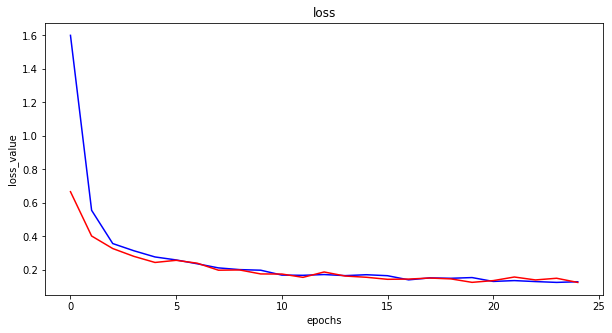

In [13]:
plt.figure(figsize=(10,5))
plt.plot(model_main.history.history['loss'],color='b',label='Training loss')
plt.plot(model_main.history.history['val_loss'],color='r',label='Validation loss')
plt.xlabel("epochs")
plt.ylabel("loss_value")
plt.title("loss")

Text(0.5, 1.0, 'accuracy graph')

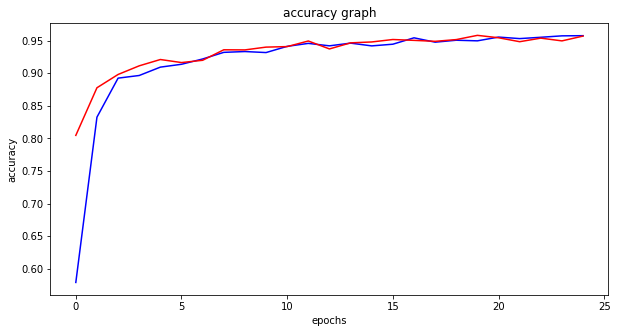

In [14]:
plt.figure(figsize=(10,5))
plt.plot(model_main.history.history['accuracy'],color='b',label='Training accuracy')
plt.plot(model_main.history.history['val_accuracy'],color='r',label='Validation accsuracy')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("accuracy graph")